


1. Denoise(completed)


  a couple of common sources of artifact that are usually in most EEG data:  

*  a bandpass filter 0.1 Hz to account for drift and 60hz to account for AC noise and also any waveforms aboe this frequency
*    I would usually perform a ICA and eliminate the blink artifact from the dataset, but between analysis of the eeg data and the lack of electrode positions, it seemed unessary and not possible in the end. Without spatial data I wouldn't know spatially where errant independent waveform compoents are originating from, such as the high concentration of a low frequency waveform near frontal lobe electrodes that would indicate blink artifact. I could say eliminate the component with a frequency and waveform similar to what I would expect in blink artifact but then it is essentially guessing and it could elminiate our actual EEG data.

  Epoch

  I performed a baseline correction followed by a artifact rejection by rejecting via threashold outside of the range of EEG values. 



2. Feature extraction (completed)
I created a visualization of the epochs of class 1 and 2 via average plots power spectrum analysis and image mapping.


The average waveform for classifier 1 appears to be noise. Looking deeper at the raw data, class 1 is periodic with an average period ranging from 1.5 seconds to 2.3 seconds. From this, I hypothesized class 1 is ekg data, however the timestamps of the signal would mean that the heart rate would be 30 bpm and the person would have bradycardia. 


3. Classify(partially completed)

 
 I used tensorflow.keras to input the data into a Convolutional neural network. I split up the epochs into roughly 200 events from each classifier into a training group and testing group with 70/30 ratio. I then made sure to run a scaler on the data before input. I then put the data thorugh a sequential neural network with a binary cross entropy loss function. This neural network was based on a paper who has done extensive testing on their own neural network on EEG data between schizophrenea patients and normal, https://www.mdpi.com/2076-3417/9/14/2870. A binary classifier seemed fitting.

Classify: (unfinished work to be completed)

Currently the neural network's best performance on test data is 56%
When I input new raw unclassified EEG data, I plan to use the same code to denoise. The only thing is that instead of epoching, I will instead create a sliding time window of [308,5]. As it steps through the voltage time series data, I will store the window as epochs to feed into the neural network. If the classfication is below a certain threshold, the NN will not label the window and move on. If it is above that threshold, the NN will label the window as 1 or 2. 

Further considerations

  A couple things I noticed about the data,
  
  1. The dataset is very small for a neural network, and as a result, the accuracy ends up varying greatly (between 48-56%) depending on which epochs I select for training vs testing. 
  
  2. A large contributer to the low accuracy I think relates to the high SNR on the class 1 classifier. 

Now unfortunetly I didn't have the time to implement the next steps I had planned, but I can lay out what I planned to do next to increase the accuracy score
1. to create more data since each of the 200 epoch of each classifier provides significant information, I plan to make multiple batches of randomly sorted test and training data, that way in separate instances of sets of test all 200 data sets get to be used. 

2. In order to make class 1 more apparent to the NN, I intend to also pump in the frequency decomposition of the waveform alongside the simple time series epochs into the neural network to allow for more fine tuning of the machine learning algorithm.



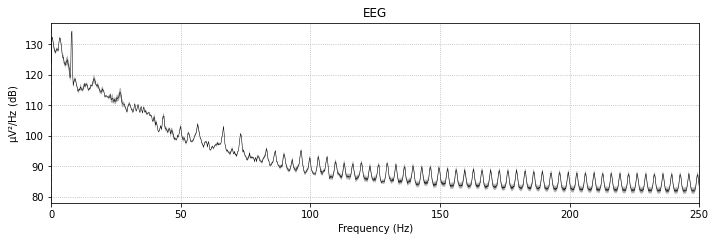

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


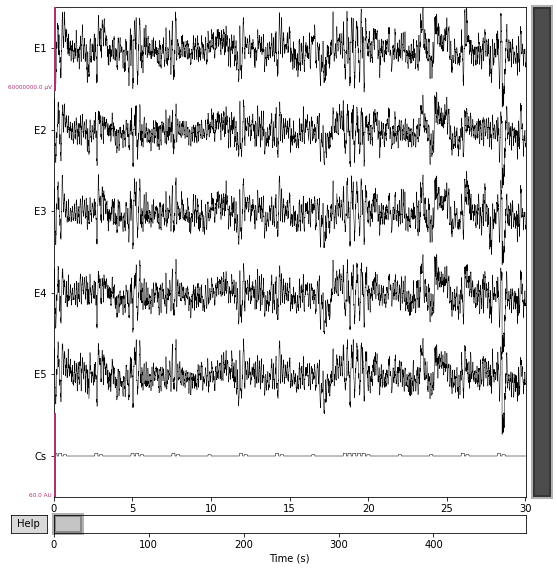

power spectral density across channels and visual inspection of eeg data, 
we can see a spike at less than 5 hz which has an obvious association to class 1


In [4]:
import numpy as np
import mne
import matplotlib.pyplot as plt
mne.set_log_level('error')
#load the data and transpose to fit dimensions of MNE format
data = np.loadtxt("data.txt")
data = np.array(data).T
#setup metadata that the raw data.txt doesn't provide 
n_channels = 6
sampling_freq = 512 
ch_names= ['E1','E2','E3','E4','E5','Cs']
ch_type= ['eeg','eeg','eeg','eeg','eeg','misc']
info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types = ch_type)

#create the raw file that stores the data for it to be filtered and manipulated 
raw = mne.io.RawArray(data, info)
# extract tags of events on the 6th channel 
events = mne.find_events(raw, stim_channel='Cs')
# start with a power spectrum to see what spikes of noise we see and can eliminate 

fig = raw.plot_psd(tmax=np.inf, fmax=250, average=True)
raw.plot(scalings = 30, duration= 30, remove_dc = False)
print("power spectral density across channels and visual inspection of eeg data, ")
print("we can see a spike at less than 5 hz which has an obvious association to class 1")








plot of psd post filtering average of all 5 channels and below that a zoomed in verson to the 10hz range


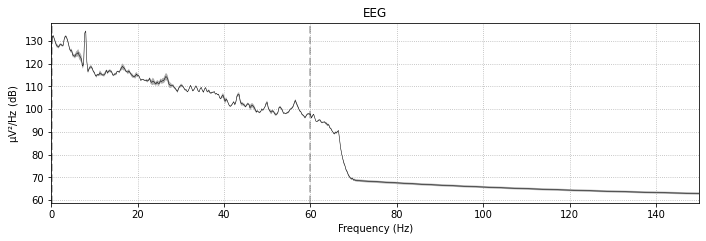

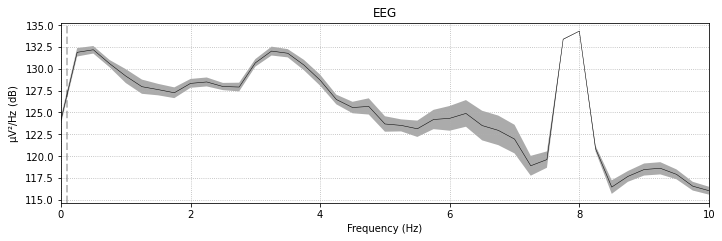

looking closer there is a huge spike at 8hz which is likely our waveform for classifier 2


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


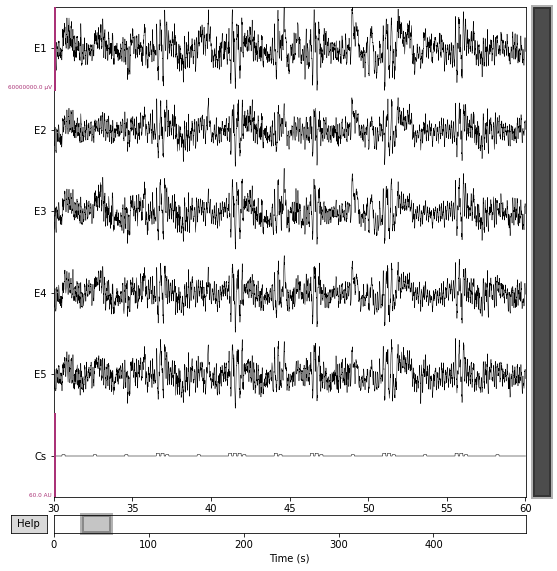

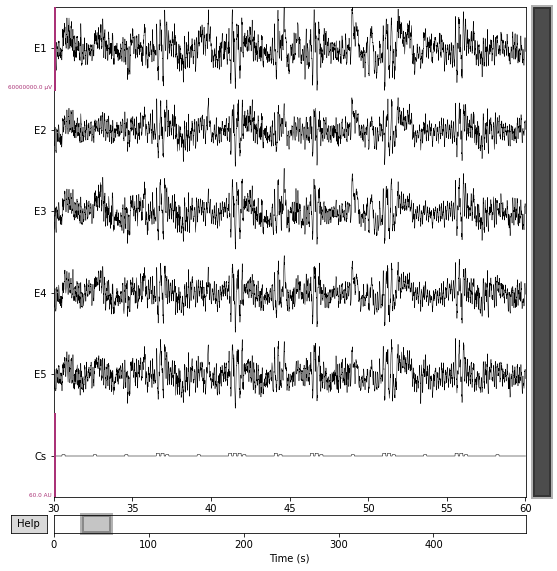

In [7]:
#denoising 
# bandpass filter to include elimination of drift at 0.1 hz and any non brain data above 60 hz including the 60hz ac line noise, based on visual inspection of eeg data 
raw.filter(0.1,60)
print('plot of psd post filtering average of all 5 channels and below that a zoomed in verson to the 10hz range')
fig = raw.plot_psd(tmax=np.inf, fmax=150, average=True)
fig = raw.plot_psd(tmax=np.inf, fmax=10, average=True)
print('looking closer there is a huge spike at 8hz which is likely our waveform for classifier 2')
raw.plot(scalings = 30, start= 30, duration= 30, remove_dc = False)



after some basic filtering, now we need to visually inspect the data for some other artifacts, there are some large negative deflections in the data
that is shown at 28s on the chart below, however I do not believe this is EOG artifact due to the large negative deflection and sporasity next one is 120 seconds later
above average signal of each of the 5 channels over classifer 1


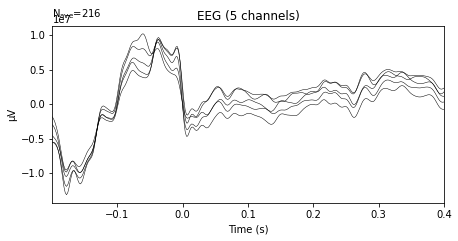

above average frequency power of each of the 5 channels over classifer 1


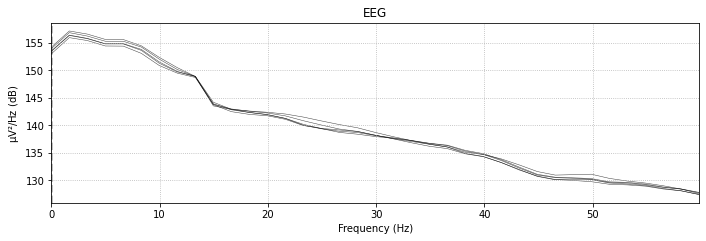

above average signal of each of the 5 channels over classifer 2


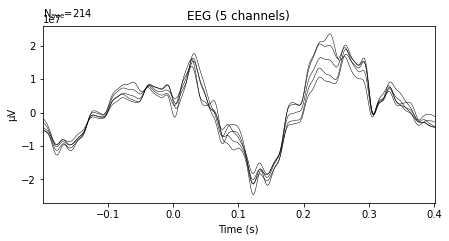

above average frequency power of each of the 5 channels over classifer 1


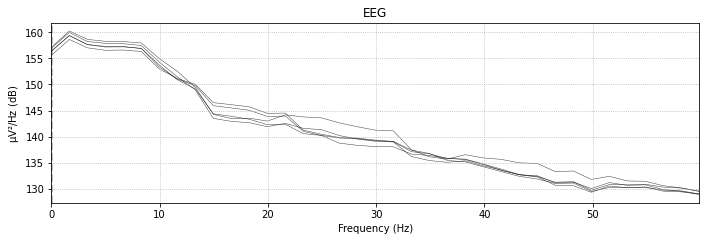

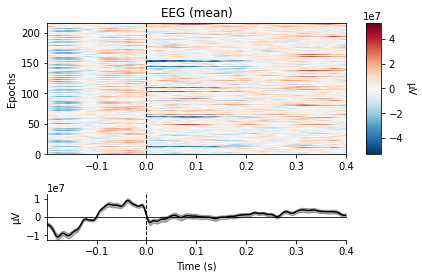

above is image map of clasifier 1


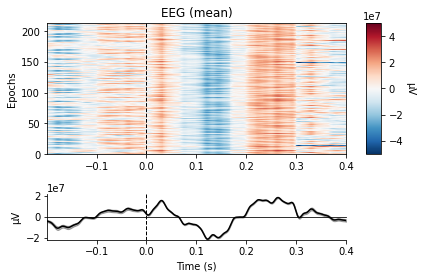

above is image map of clasifier 2


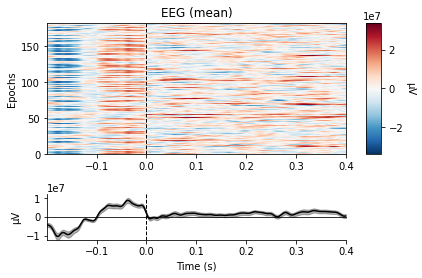

above is image map of clasifier 1 with dropped extreme values


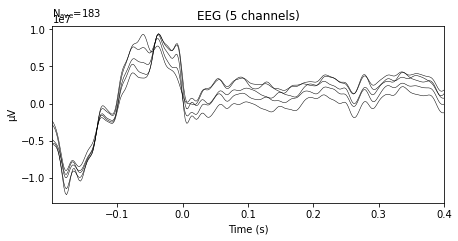

above is average 5 channels of clasifier 1 with dropped extreme values
classifier 2 has a clear waveform with an image map with approximately p50 n120 p250
classifier 1 had me stumped for a while as the it seemed to apparent noise after 0 second
even after dropping channels it still is noisy this leads me to believe that the frequecy and amplitude of the waveform
be hidden in the noise and the S/R is a lot higher.


In [8]:
# epoching for rejection of one off noisy components 
# multichannel plotting code to see individual epochs on top one another


print('after some basic filtering, now we need to visually inspect the data for some other artifacts, there are some large negative deflections in the data')
print('that is shown at 28s on the chart below, however I do not believe this is EOG artifact due to the large negative deflection and sporasity next one is 120 seconds later')
# epoch with baseline of .2 seconds before signal starts with rejection 
interval = (-0.2,0)
epochs_1 = mne.Epochs(raw, events, event_id = 1, baseline = interval, tmax=0.4 )
epochs_2 = mne.Epochs(raw, events, event_id = 2, baseline = interval, tmax =0.4 )

print('above average signal of each of the 5 channels over classifer 1')
epochs_1.average().plot()
print('above average frequency power of each of the 5 channels over classifer 1')
epochs_1.plot_psd(fmax=60)
print('above average signal of each of the 5 channels over classifer 2')
epochs_2.average().plot()
print('above average frequency power of each of the 5 channels over classifer 1')
epochs_2.plot_psd(fmax=60)


epochs_1.plot_image(picks = ['eeg'], combine = 'mean')
print('above is image map of clasifier 1')
epochs_2.plot_image(picks = ['eeg'], combine = 'mean')
print('above is image map of clasifier 2')
reject_criteria = dict( eeg=55 )  
reject_epochs_1= mne.Epochs(raw, events, event_id = 1, baseline = interval, reject = reject_criteria, tmax=0.4 )

reject_epochs_1.plot_image(picks = ['eeg'], combine = 'mean')
print('above is image map of clasifier 1 with dropped extreme values')
reject_epochs_1.average().plot()
print('above is average 5 channels of clasifier 1 with dropped extreme values')
ch_index = 1 
print('classifier 2 has a clear waveform with an image map with approximately p50 n120 p250')
print ('classifier 1 had me stumped for a while as the it seemed to apparent noise after 0 second')
print ('even after dropping channels it still is noisy this leads me to believe that the frequecy and amplitude of the waveform')
print('be hidden in the noise and the S/R is a lot higher.')






In [ ]:
!pip install tensorflow
!pip install keras


In [10]:
from numpy.core.fromnumeric import shape

# classification
# classification will be done via CNN, the data is preprocessed and epoched now and ready to be fed into the CNN

# 1. convert epoch and labels from list to array to prep for feeding the neural netwok 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

epochs_1ar = epochs_1.get_data(picks = ['E1','E2','E3','E4','E5'] )
epochs_2ar = epochs_2.get_data(picks = ['E1','E2','E3','E4','E5'] )
events_1 = [1]*len(epochs_1ar)
events_2 = [2]*len(epochs_2ar)
epochs_labels=np.concatenate([events_1, events_2])
epochs_array=np.concatenate((epochs_1ar, epochs_2ar), axis=0)



#format is number of events, number of channels, time points 
epochs_array = np.moveaxis(epochs_array,1,2)

X_train, X_test, Y_train, Y_test = train_test_split(epochs_array,epochs_labels,train_size=0.7,random_state=4)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(epochs_array,epochs_labels,train_size=0.9,random_state=106)

scaler= StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1,X_test.shape[-1])).reshape(X_test.shape)




# 2. create the recurrent neural network model
import tensorflow as tf

from tensorflow.keras.layers import Conv1D, BatchNormalization, LeakyReLU, MaxPool1D, GlobalAveragePooling1D, Dense, Dropout, AveragePooling1D
#types of layers we plan to use
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
# plan to use a simple sequential network 
from tensorflow.keras.backend import clear_session
#this model is what I was used to building in my ML classes convolutions followed by normalization, actication then pooling 
# though the results were not as nice as I'd like it to be

def cnnmodel():
  clear_session()
  model=Sequential()
  #1
  model.add(Conv1D(filters=5, kernel_size=3,strides=1,input_shape=(308,5))) #shape number of events by channels
  model.add(BatchNormalization())
  model.add(LeakyReLU())
#2
  model.add(MaxPool1D(pool_size = 2, strides =2))
#3
  model.add(Conv1D(filters=5,kernel_size=3, strides=1))
  model.add(LeakyReLU())
#4
  model.add(MaxPool1D(pool_size=2, strides=2))
  model.add(Dropout(0.5)) #prevent overfitting 
#5
  model.add(Conv1D(filters=5, kernel_size=3, strides=1))
  model.add(LeakyReLU())
#6
  model.add(AveragePooling1D(pool_size=2, strides=2))
  model.add(Dropout(0.5))
#7  
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))
  model.add(LeakyReLU())
#8
  model.add(AveragePooling1D(pool_size=2, strides=2))
#9
  model.add(Conv1D(filters=5,kernel_size=3,strides=1))
  model.add(LeakyReLU())
#10
  model.add(GlobalAveragePooling1D())
#11
  model.add(Dense(1,activation='sigmoid'))
  #binary_crossentropy because we have a binary classifier either 1 or 2
  model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model

def cnnmodel2():
  clear_session()
  model = Sequential()
  model.add(Dense(128, input_shape= (308,5),activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(32))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(16))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(8))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(4))
  model.add(Activation('relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
  return model







model = cnnmodel()

model.summary()
print("Fit model on training data")




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 306, 5)            80        
                                                                 
 batch_normalization (BatchN  (None, 306, 5)           20        
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 306, 5)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 153, 5)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 151, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 151, 5)            0

In [103]:
#training model loop 
history = model.fit(
    X_train,
    Y_train,
    batch_size=10,
    epochs=100,
    validation_data=(X_test, Y_test),
)






Epoch 1/100
31/31 [==============================] - 4s 39ms/step - loss: 0.1656 - accuracy: 0.4751 - val_loss: -0.2302 - val_accuracy: 0.5659
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: -1.1254 - accuracy: 0.4751 - val_loss: -2.1491 - val_accuracy: 0.5659
Epoch 3/100
31/31 [==============================] - 1s 23ms/step - loss: -4.9531 - accuracy: 0.4751 - val_loss: -8.5388 - val_accuracy: 0.5659
Epoch 4/100
31/31 [==============================] - 1s 18ms/step - loss: -20.7486 - accuracy: 0.4751 - val_loss: -31.8507 - val_accuracy: 0.5659
Epoch 5/100
31/31 [==============================] - 1s 19ms/step - loss: -71.6701 - accuracy: 0.4751 - val_loss: -100.1818 - val_accuracy: 0.5659
Epoch 6/100
31/31 [==============================] - 1s 22ms/step - loss: -232.7011 - accuracy: 0.4751 - val_loss: -263.3244 - val_accuracy: 0.5659
Epoch 7/100
31/31 [==============================] - 1s 17ms/step - loss: -648.3085 - accuracy: 0.4751 - val_loss: -654.4921 - v

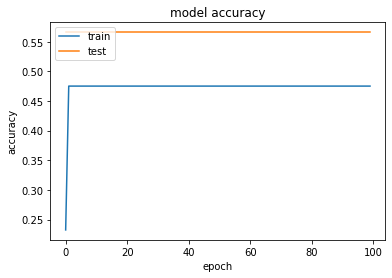

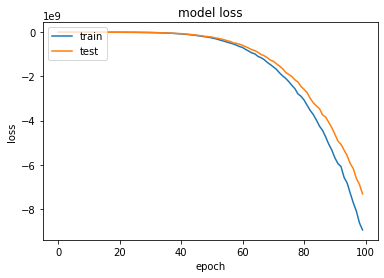

In [99]:
# visualization of the model's performance 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# run the model though some epochs to create weights

#load new data into the model

# iterate though the new raw eeg model and only if the model matches more than 50% we can say its a match 

#output the values of matches to an index to mark where either class 1 or class 2 are seen 